In [1]:
import os
import multiprocessing as mp
import glob
import matplotlib.pyplot as plt
import skimage
from itertools import repeat
from tqdm import tqdm_notebook as tqdm
from utils import *

## Generate the Zernike terms from 0th to 21th

In [ ]:
# saveDir = './zernikemap/'
# for idx in range(len(opticspy.zernike.Coefficient().__zernikelist__[0] )):
#     initial = opticspy.zernike.Coefficient()
#     if idx is 0:
#         initial.__coefficients__[idx] = 0
#     else:
#         initial.__coefficients__[idx] = 1
    
# #     filepath = saveDir + 'z' + str(idx+1) +'.png'
#     filepath = ''
#     initial.zernikemap(label=False, filepath=filepath)

## Basic Parameters

In [3]:
### coefficients for generating RBC
c0 = 0.2072
c1 = 2.0026
c2 = -1.1228

### refractive index of RBC and medium
n_rbc = 1.395
n_med = 1.334

### the radius of RBC in um
R = 3.9               #(um)

### wavelength of light source
wavelength = 0.532    #(um)

### the pixelsize of CMOS and magnification on optics setup
dx = 5.5             #(um)
mag = 85

### calcuate the grid number of RBC
grids = round((R*2) / (dx/mag))    # Ngrid= (2 x radius) / actural size per pixel

cmap = plt.cm.gray

### plugin number
plug_no = 2    #1: opticspy; 2: prysm

## Generate the RBC phase distributionn

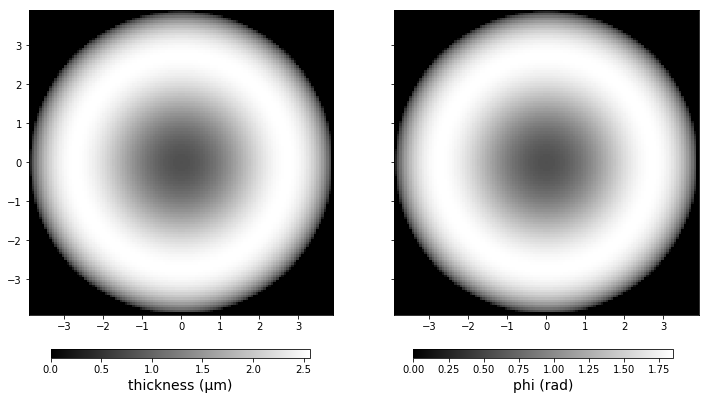

In [4]:
S = np.zeros((grids,grids))
halfGrids = grids//2
for y in range(-halfGrids, halfGrids):
    for x in range(-halfGrids, halfGrids):
        px = x+halfGrids
        py = y+halfGrids
        r = np.sqrt(x*x+y*y) * (dx/mag)
        if r < R:
            S[py,px] = np.sqrt(1-np.power((r/R),2))*(c0+c1*np.power((r/R),2)+c2*np.power((r/R),4)) * R
        else:
            S[py,px] = 0
                    
phasemap = np.zeros_like(S)
phasemap = S*2*np.pi/wavelength*(n_rbc-n_med)
            
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6),sharex=True, sharey=True)
ax1 = axes[0]
ax2 = axes[1]
im1=ax1.imshow(S, cmap, extent=(-R, R, -R, R))
im2=ax2.imshow(phasemap, cmap, extent=(-R, R, -R, R))

cbar_ax1 = fig.add_axes([0.15, 0.05, 0.3, 0.02]) 
cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal').set_label(label='thickness (μm)',size=14)
                                                                           
cbar_ax2 = fig.add_axes([0.57, 0.05, 0.3, 0.02]) 
cbar1 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal').set_label(label='phi (rad)',size=14)

plt.show()

## Defint I/O function for QPIs

## Build an 3-D RBC model

In [5]:
S_3D = np.zeros((grids,grids,grids)).astype(np.float)
S_3D[:,:,:] = 0
halfGrids = grids//2

for y in range(-halfGrids, halfGrids):
    for x in range(-halfGrids, halfGrids):
        px = x+halfGrids
        py = y+halfGrids
        r = np.sqrt(x*x+y*y)
        if r < halfGrids:
            rz = int(0.5*halfGrids*np.sqrt(1-(x*x+y*y)/(halfGrids*halfGrids)) * (c0 + c1*(x*x+y*y)/(halfGrids*halfGrids) + c2*np.power((x*x+y*y),2)/np.power(halfGrids,4)))
            S_3D[px,py,halfGrids-rz:halfGrids+rz] = n_rbc
            

# for z in range(-halfGrids, halfGrids):            
#     for y in range(-halfGrids, halfGrids):
#         for x in range(-halfGrids, halfGrids):
#             px = x+halfGrids
#             py = y+halfGrids
#             pz = z+halfGrids
#             r = np.sqrt(x*x+y*y+z*z)
#             if r < halfGrids//3*2:
#                 S_3D[px,py,pz] = n_rbc
                
# S_3D -= n_med

In [6]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.transform import resize
iMin = np.min(S_3D)
iMax = np.max(S_3D)
def f(x):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6),sharex=True, sharey=True)
    im1=axes.imshow(S_3D[:,:,x],vmin=iMin, vmax=iMax, cmap=plt.cm.jet, extent=(-R, R, -R, R))

    cbar_ax1 = fig.add_axes([0.18, 0.05, 0.7, 0.02]) 
    cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal').set_label(label='Refractive index (a.u.)',size=14)
#     plt.imshow(reconRI[:,:,x],vmin=iMin, vmax=iMax, cmap=plt.cm.jet)
    plt.show()

interact(f, x=widgets.IntSlider(min=0,max=np.shape(S_3D)[2]-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='x', max=120), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

In [7]:
import cupy
from cupyx.scipy import ndimage

angs=[]
projs =[]
for ang in range (0,180,1):
    tmp3D = ndimage.rotate(cupy.array(S_3D), ang, axes=(1,2), reshape=False)
    proj = np.sum(cupy.asnumpy(tmp3D), axis = 2)*(1/(2*np.pi/wavelength))
    angs.append(ang)
    projs.append(proj)
angs=np.array(angs)

from skimage.transform import iradon, iradon_sart

frames, ny, nx = np.shape(projs)
sinogram = np.zeros((ny, frames)).astype(np.float)
reconRI = np.zeros((ny,ny,ny)).astype(np.float)
iterNum = 2
method = 2
for line in tqdm(range(0,ny)):
    for frame in range (0, frames):
        sinogram[:,frame] = projs[frame][:,line]
        
    if method is 1:
        reconstruction_sart = iradon_sart(sinogram, theta=angs)
        for iter in range(0,iterNum):
            reconstruction_sart = iradon_sart(sinogram, theta=angs, image=reconstruction_sart)
            reconstruction_fbp[reconstruction_fbp<n_med] = n_med
            reconRI[:,:,line] = reconstruction_sart
    else:
        reconstruction_fbp = iradon(sinogram, theta=angs, circle=True)
        reconRI[:,:,line] = reconstruction_fbp


In [8]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.transform import resize
iMin = np.min(reconRI)
iMax = np.max(reconRI)
def f(x):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6),sharex=True, sharey=True)
    im1=axes.imshow(reconRI[:,:,x],vmin=iMin, vmax=iMax, cmap=plt.cm.jet, extent=(-R, R, -R, R))

    cbar_ax1 = fig.add_axes([0.18, 0.05, 0.7, 0.02]) 
    cbar1 = fig.colorbar(im1, cax=cbar_ax1, orientation='horizontal').set_label(label='Refractive index (a.u.)',size=14)
#     plt.imshow(reconRI[:,:,x],vmin=iMin, vmax=iMax, cmap=plt.cm.jet)
    plt.show()

interact(f, x=widgets.IntSlider(min=0,max=np.shape(reconRI)[2]-1,step=1,value=0))

interactive(children=(IntSlider(value=0, description='x', max=120), Output()), _dom_classes=('widget-interact'…

<function __main__.f(x)>

(121, 121)


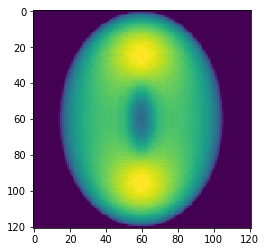

In [9]:
import cupy
from cupyx.scipy import ndimage
tmp3D = ndimage.rotate(cupy.array(S_3D), -50, axes=(1,2), reshape=False)
proj = np.sum(cupy.asnumpy(tmp3D), axis = 2)*(1/(2*np.pi/wavelength))
print(np.shape(proj))
plt.imshow(proj)

## Simulate the RBC projection from 0 to 170 degrees, and fit the abberation by Zernike polyminals

In [ ]:
thetaN = 36
phiN = 36
rotation = np.linspace(0,360, num=thetaN, endpoint=False).astype(np.int)
# orientation = np.linspace(-180,180, num=phiN, endpoint=False).astype(np.int)
orientation = 0
args = []

for theta in np.nditer(rotation):
    for phi in np.nditer(orientation):
        args.append((float(theta),float(phi)))
        

pool = mp.Pool(8)
zc_list = [pool.starmap(zernikeFitting, zip(repeat(S_3D), repeat(wavelength), rotation, repeat(orientation), repeat(1)))] 
pool.close()
pool.join()

zc = np.array(zc_list)

if plug_no is 1:
    c1 = zc[:,:,2]
    c2 = zc[:,:,3]
    c4 = zc[:,:,4]
elif plug_no is 2:
    c1 = zc[:,:,1]
    c2 = zc[:,:,2]
    c4 = zc[:,:,3]

In [ ]:
cosline = np.power(np.cos(np.arange(0,360)*np.pi/180),2)
norm_c4 = normalize(c4)

fig, ax = plt.subplots()

ax.scatter(rotation, norm_c4, c='r', marker='x')
ax.plot(np.arange(0,360), cosline, 'b-')
ax.set(xlabel='Rotation (degree)', ylabel='Normalized C4 (a.u.)',
       title='c4 vs. $cos^{2}$(θ)')
plt.show()

In [ ]:
thetaN = 36
phiN = 36
rotation = np.linspace(0,360, num=thetaN, endpoint=False).astype(np.int)
# orientation = np.linspace(-180,180, num=phiN, endpoint=False).astype(np.int)
orientation = 0
args = []

for theta in np.nditer(rotation):
    for phi in np.nditer(orientation):
        args.append((float(theta),float(phi)))
        

pool = mp.Pool(8)
zc_list = [pool.starmap(zernikeFitting, zip(repeat(S_3D), repeat(wavelength), rotation, repeat(orientation), repeat(2)))] 
pool.close()
pool.join()

zc = np.array(zc_list)

if plug_no is 1:
    c1 = zc[:,:,2]
    c2 = zc[:,:,3]
    c4 = zc[:,:,4]
elif plug_no is 2:
    c1 = zc[:,:,1]
    c2 = zc[:,:,2]
    c4 = zc[:,:,3]

In [ ]:
cosline = np.power(np.cos(np.arange(0,360)*np.pi/180),2)
norm_c4 = normalize(c4)

fig, ax = plt.subplots()

ax.scatter(rotation, norm_c4, c='r', marker='x')
ax.plot(np.arange(0,360), cosline, 'b-')
ax.set(xlabel='Rotation (degree)', ylabel='Normalized C4 (a.u.)',
       title='c4 vs. $cos^{2}$(θ)')
plt.show()

In [ ]:
tt = np.arctan2(c1,c2)*180/np.pi

fig, ax = plt.subplots()

ax.scatter((rotation-180), tt, c='r', marker='x')
ax.plot((rotation-180), (rotation-180), 'b-')
ax.set(xlabel='Orientation (degree)', ylabel='Measurement angle (degree)',
       title='$tan^{-1}$(c1/c2) vs. orientation')
plt.show()

## Older version (without multiprocessing)

In [ ]:
# rotation = np.linspace(0,360, num=36, endpoint=False).astype(np.int)

# nrows=6
# ncols=6
# fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12),sharex=True, sharey=True)

# phasemap_list = []
# zc_list = []
# nr=1024
# nc=1024
# tmpPM = np.zeros((nr,nc))
# sr=(nr-grids)//2
# er=sr+grids
# sc=(nc-grids)//2
# ec=sc+grids

# outputDir = './Simualted_RBC'
# for theta in tqdm(np.nditer(rotation)):
#     newe_S = rotate(S_3D, theta, axes=(1,2), reshape=False)
    
#     proj = np.sum(newe_S, axis = 2)*(dx/mag)
#     phasemap = proj*2*np.pi/wavelength*(n_rbc-n_med)
#     c = theta//10%ncols
#     r = (theta//10-c)//ncols
#     ax = axes[r,c]
#     ax.imshow(phasemap, cmap, extent=(-R, R, -R, R))
    
#     ZC,C = opticspy.zernike.fitting(phasemap,10, display=False)
#     tmpPM[sr:er,sc:ec]=phasemap
#     zc_list.append(ZC)
#     phasemap_list.append(tmpPM)
    
#     if not os.path.exists(outputDir):
#         os.makedirs(outputDir)
#     SavePath = '%s/buffer%03d.phimap' %(outputDir,int(theta/10)+1)
#     exportPM(SavePath, True, theta*np.pi/180, 0.0, nr, nc, tmpPM)
    
# plt.show()
# zc = np.array(zc_list)

In [ ]:
# !cp -f -R /media/share/HDD2TB/Zernike/Simualted_RBC/ /media/share/MIC110/UntitledFolder/

## Estimation of the FSA, SSA and Coma

In [ ]:
# FSA = opticspy.zernike.Coefficient(Z3=ZC[3], Z4=ZC[4], Z5=ZC[5])
# SSA = opticspy.zernike.Coefficient(Z11=ZC[11], Z12=ZC[12], Z13=ZC[13])
# Coma = opticspy.zernike.Coefficient(Z7=ZC[7], Z8=ZC[8])
# FSA.zernikemap(label=False)
# SSA.zernikemap(label=False)
# Coma.zernikemap(label=False)

## Define the functions for loading data and cropping the RBC area

In [ ]:
from scipy.ndimage import zoom, measurements

N = 128

def importRI(filePath):    
    RI = np.fromfile(filePath, dtype=np.float32).reshape((512,512,512))
    RI = np.transpose(RI, (2, 1, 0))
#     RI = RI[::-1,:,:]
    print(RI[256,256,256])
    return RI

def cropRI(image):
    if(len(np.shape(image)) is 3):
        (nx, ny, nz) = np.shape(image)
        if nx == ny and ny == nz:
            R1 = nx//2-N
            R2 = R1+N*2
            crop_img = image[R1:R2, R1:R2, R1:R2]
            resize = zoom(crop_img,(0.5,0.5,0.5))
            
            # get binary image and center of mass
            thresh = skimage.filters.threshold_otsu(resize)
            binary = resize > thresh    #elimating small objects might be helpful
            center_of_mass = measurements.center_of_mass(binary)
            
            cy, cx, cz = center_of_mass        
            fig, ax = plt.subplots()
            im = ax.imshow(np.sum(binary, axis = 2))
            ax.plot(cx, cy, 'x')
            plt.show()

            #recrop the RI
            x1 = (int)(cx*2) - N//2
            if x1 < 0:
                x1 = 0
            elif x1 + N >nx:
                x1 = nx - N;
            x2 = x1 + N
            
            y1 = (int)(cy*2) - N//2
            if y1 < 0:
                y1 = 0
            elif y1 + N > ny:
                y1 = ny - N;
            y2 = y1 + N
            
            z1 = (int)(cz*2) - N//2
            if z1 < 0:
                z1 = 0
            elif z1 + N > nz:
                z1 = nz - N;
            z2 = z1 + N
                
            crop_img = crop_img[y1:y2, x1:x2, z1:z2]
            thresh = skimage.filters.threshold_otsu(crop_img)
            binary = crop_img > thresh
            crop_img[binary==False]=0
            return crop_img, center_of_mass
    else:
        return np.ones((N,N,N)), (0,0,0)

In [ ]:
ri_folder = []
ri_folder.append('/media/share/HDD2TB/cTDM/RI/healthy/0419sun_532/')

for idx, folder in enumerate(ri_folder):
    print(folder)
    
    for file_RI in tqdm(glob.glob(folder + '*.raw')[:1]):
        print(file_RI)
        rimap, cent = cropRI(importRI(file_RI))

In [ ]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.transform import resize
def f(x):    
#     plt.figure(figsize=(10,10))
    plt.imshow(rimap[:,:,x], cmap=plt.cm.jet)
    plt.show()
#     print('File: %s \nAP/LAT: %s \nDisease: %s \nFrames: %s '%(df['file'][x],df['view'][x],df['type'][x],df['frames'][x]))

interact(f, x=widgets.IntSlider(min=0,max=np.shape(rimap)[2]-1,step=1,value=0))

In [ ]:
rotation = np.linspace(0,10, num=20, endpoint=False)
for theta in tqdm(np.nditer(rotation)):
    print(theta)

In [ ]:
rotation = np.linspace(0,360, num=360, endpoint=False)

nrows=6
ncols=6
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12),sharex=True, sharey=True)

phasemap_list = []
zc_list = []
nr=1024
nc=1024
tmpPM = np.zeros((nr,nc))
sr=(nr-grids)//2
er=sr+grids
sc=(nc-grids)//2
ec=sc+grids

outputDir = '/media/share/HDD2TB/BatchRecon/Projections_test/'
count=0
for theta in tqdm(np.nditer(rotation)):
    newe_S = rotate(S_3D, theta, axes=(1,2), reshape=False)
    
    proj = np.sum(newe_S, axis = 2)*(1/(2*np.pi/wavelength))
    phasemap = proj*2*np.pi/wavelength*(n_rbc-n_med)
#     c = theta//10%ncols
#     r = (theta//10-c)//ncols
#     ax = axes[r,c]
#     ax.imshow(proj, cmap)
    
    ZC,C = opticspy.zernike.fitting(proj, 37, display=False)
#     ZC = zernike.zernikefit(proj, norm=True, terms=37, map_='noll') 
    tmpPM[sr:er,sc:ec]=phasemap
    zc_list.append(ZC)
    phasemap_list.append(tmpPM)
    
    if not os.path.exists(outputDir):
        os.makedirs(outputDir)
    SavePath = '%s/buffer%03d.phimap' %(outputDir,count)
    exportPM(SavePath, True, theta*np.pi/180, 0.0, nr, nc, tmpPM)
    count = count+1
    
plt.show()
zc = np.array(zc_list)